In [6]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc, current_mirror_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

# LDO exploration with IHP130: Cascode differential pair and cascode active load

In [7]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                      # LDO output voltage
Vin = 3.3                                       # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                     # Load current
CL = 1e-12                                      # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.999
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3


I_amp =10e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

## 1. Preparation

### Macromodels

In [8]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 2.5, 5)  # this will be used in the near future

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_diff_m1"), 
                                  Symbol("L_diff_m1"), 
                                  Symbol("W_diff_m2"), 
                                  Symbol("L_diff_m2"), 
                                  Symbol("W_al_m1"), 
                                  Symbol("L_al_m1"), 
                                  Symbol("W_al_m2"), 
                                  Symbol("L_al_m2"), 
                                  Symbol("W_pt"), 
                                  Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = {"max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3]}

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_ccdiff = Macromodel(name = "ota_ccdiff",
                       outputs = [Symbol("W_diff_m1"), 
                                  Symbol("L_diff_m1"), 
                                  Symbol("W_diff_m2"), 
                                  Symbol("L_diff_m2"), 
                                  Symbol("W_aload_m1"), 
                                  Symbol("L_aload_m1"),
                                  Symbol("W_aload_m2"), 
                                  Symbol("L_aload_m2")],
                       req_tfs = [["vout", "vpos"], 
                                  ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={"Vdd": LDO_macro.electrical_parameters["Vdd"],
                                              "Vref": LDO_macro.electrical_parameters["Vref"],
                                              "Vout": LDO_macro.electrical_parameters["Vaout"],
                                              "I": I_amp}
                      )

OTA_ccdiff.area_conditions = {"max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3],
                              "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 5e-6, 0]}

### Primitives

In [9]:
pt_bc = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': IL+Ib_pt,
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt_bc.build()

pt_bc.parameters = {Symbol('gm_pt'): np.asarray(pt_bc.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt_bc.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt_bc.cgg).flatten()+np.asarray(pt_bc.cgd).flatten()*np.asarray(pt_bc.gm).flatten()*np.asarray(pt_bc.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt_bc.cgd).flatten()}
pt_bc.outputs = {Symbol("W_pt"): np.asarray(pt_bc.W).flatten(),
              Symbol("L_pt"): np.asarray(pt_bc.L).flatten()}

length
vgs
0


In [10]:
vg_wc = -0.5349

pt_wc = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': vg_wc, 
                     'il': Ib_pt,
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt_wc.build()

pt_wc.parameters = {Symbol('gm_pt'): np.asarray(pt_wc.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt_wc.cgg).flatten()+np.asarray(pt_wc.cgd).flatten()*np.asarray(pt_wc.gm).flatten()*np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt_wc.cgd).flatten()}
pt_wc.outputs = {Symbol("W_pt"): np.asarray(pt_bc.W).flatten(),
              Symbol("L_pt"): np.asarray(pt_bc.L).flatten()}



length
vgs
0


In [11]:
## PASS TRANSISTOR PRIMITIVE ###############################################################

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt.cgg).flatten()+np.asarray(pt.cgd).flatten()*np.asarray(pt.gm).flatten()*np.asarray(pt.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt.cgd).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## DIFF PAIR PRIMITIVE #####################################################################

sweep_size_dp = 3
vin_dp = OTA_ccdiff.electrical_parameters["Vref"]
vout_dp = OTA_ccdiff.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(vcp_dp, vs_dp, vin_dp, vout_dp, I_amp, sweep_size_dp, lengths, vout_dp + 0.5)
diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 ########################
                                 Symbol("vbias"): np.asarray(diffpair_primitive.vbias).flatten(), 
                                 Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_1"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_1"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 Symbol("Coutdif"): np.asarray(np.abs(diffpair_primitive.cout)).flatten(),
                                 Symbol("Ccp"): np.asarray(np.abs(diffpair_primitive.ccp)).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

vout_cm = 1.7 - 3.3 
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, vout_cm+1.6, sweep_size_cm)

activeload_primmitive = current_mirror_cc(vcp_cm, vout_cm, I_amp, sweep_size_cm, lengths, vout_cm - 0.5)
activeload_primmitive.build()

activeload_primmitive.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive.Ro).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive.gm).flatten(),
                                    Symbol("Cout"): np.asarray(activeload_primmitive.cout).flatten(),
                                    Symbol("Ccp_m1"): np.asarray(activeload_primmitive.ccp_m1).flatten(),
                                    Symbol("Ccp_m2"): np.asarray(activeload_primmitive.ccp_m2).flatten(),
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive.vbias).flatten()}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

length
vgs
0
vds
vgs
1
M1 jd:  [[7.25617454e+01 1.80845817e+00 6.08249885e-07 7.34084543e+01
  1.90120061e+00 6.81829196e-07 7.42184014e+01 1.99635755e+00
  7.41052912e-07]
 [2.68475066e+01 4.21686384e-01 5.76879734e-08 2.70161958e+01
  4.31455662e-01 6.12480740e-08 2.71720535e+01 4.41158333e-01
  6.32482759e-08]
 [1.33920261e+01 3.20830019e-01 9.84013468e-08 1.34308666e+01
  3.24229363e-01 1.01240520e-07 1.34668188e+01 3.27472890e-01
  1.02400065e-07]
 [6.77136134e+00 2.02576492e-01 1.00439538e-07 6.78141779e+00
  2.03654438e-01 1.02074952e-07 6.79065407e+00 2.04665256e-01
  1.02550571e-07]
 [3.40715906e+00 1.13132608e-01 7.25296697e-08 3.40978209e+00
  1.13438949e-01 7.33387728e-08 3.41217923e+00 1.13727975e-01
  7.35222146e-08]]
M1 gmid:  [[ 2.69279641 14.6328196  25.30420007  2.68099255 14.43691294 25.37605575
   2.66803299 14.24215868 25.40744333]
 [ 3.30401794 16.94849873 27.22257732  3.30213304 16.87704111 27.24312789
   3.29890682 16.80351106 27.22820591]
 [ 3.25801581 14.14441

In [12]:
diffpair_primitive_wc = diffpair_cc(vcp_dp, vs_dp, vin_dp, 3.3+vg_wc, I_amp, sweep_size_dp, lengths, vout_dp + 0.5)
diffpair_primitive_wc.build()      

diffpair_primitive_wc.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive_wc.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive_wc.gm).flatten(),
                                 Symbol("Rdif_2"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_2"): np.asarray(diffpair_primitive.gm).flatten(),
                                 ########################
                                 Symbol("Cgd"): np.asarray(diffpair_primitive_wc.cgd_m1).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive_wc.cgs_m1).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive_wc.vbias).flatten(), 
                                 ########################
                                 Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive_wc.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_1"): np.asarray(diffpair_primitive_wc.gm_m1).flatten(),
                                 Symbol("Rdif_m1_2"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_2"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 ########################
                                 Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive_wc.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_1"): np.asarray(diffpair_primitive_wc.gm_m2).flatten(),
                                 Symbol("Rdif_m2_2"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_2"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 ########################
                                 Symbol("Cds_m1"): np.asarray(np.abs(diffpair_primitive_wc.cds_m1)).flatten(),
                                 Symbol("Cgs_m2"): np.asarray(np.abs(diffpair_primitive_wc.cgs_m2)).flatten(),
                                 Symbol("Cgd_m2"): np.asarray(np.abs(diffpair_primitive_wc.cgd_m2)).flatten()}

diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

activeload_primmitive_wc = current_mirror_cc(vcp_cm, vg_wc, I_amp, sweep_size_cm, lengths, vout_cm - 0.5)
activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive_wc.gm_m2*activeload_primmitive_wc.Ro_m2*activeload_primmitive.Ro_m1).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("Raload_2"): np.asarray(activeload_primmitive.Ro).flatten(),
                                    Symbol("gaload_2"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive_wc.vbias).flatten()}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

vds
vgs
1
M1 jd:  [[7.25617454e+01 1.80845817e+00 6.08249885e-07 7.34084543e+01
  1.90120061e+00 6.81829196e-07 7.42184014e+01 1.99635755e+00
  7.41052912e-07]
 [2.68475066e+01 4.21686384e-01 5.76879734e-08 2.70161958e+01
  4.31455662e-01 6.12480740e-08 2.71720535e+01 4.41158333e-01
  6.32482759e-08]
 [1.33920261e+01 3.20830019e-01 9.84013468e-08 1.34308666e+01
  3.24229363e-01 1.01240520e-07 1.34668188e+01 3.27472890e-01
  1.02400065e-07]
 [6.77136134e+00 2.02576492e-01 1.00439538e-07 6.78141779e+00
  2.03654438e-01 1.02074952e-07 6.79065407e+00 2.04665256e-01
  1.02550571e-07]
 [3.40715906e+00 1.13132608e-01 7.25296697e-08 3.40978209e+00
  1.13438949e-01 7.33387728e-08 3.41217923e+00 1.13727975e-01
  7.35222146e-08]]
M1 gmid:  [[ 2.69279641 14.6328196  25.30420007  2.68099255 14.43691294 25.37605575
   2.66803299 14.24215868 25.40744333]
 [ 3.30401794 16.94849873 27.22257732  3.30213304 16.87704111 27.24312789
   3.29890682 16.80351106 27.22820591]
 [ 3.25801581 14.14441611 27.018865

### Testbenches

In [13]:
#################### PSRR LDO MACRO #######################
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo_psrr"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [1]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = Test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                           Symbol("V2"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("Cc"): 1e-12,
                           Symbol("R1"): 100000,
                           Symbol("R2"): 300000}

bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = Test()
loadreg_LDO_macro.name = 'loadreg_LDO'
loadreg_LDO_macro.tf = ["vout", "vdd"]
loadreg_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 3.3,
                                Symbol("V2"): 1.35,
                                Symbol("s"): 0,
                                Symbol("Cl"): CL,
                                Symbol("Cc"): 1e-12,
                                Symbol("R1"): 100000,
                                Symbol("R2"): 300000}

loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

##################### OPENLOOP ######################################

ol_gain_LDO_macro = Test()
ol_gain_LDO_macro.name = "ol_gain_LDO"
ol_gain_LDO_macro.tf = ["vout", "vol"]
ol_gain_LDO_macro.netlist = "ldo_ol"
ol_gain_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

ol_gain_LDO_macro.opt_goal = "min"
ol_gain_LDO_macro.conditions = {"min": [1]}
ol_gain_LDO_macro.variables = {}
ol_gain_LDO_macro.out_def = {"eval": ol_gain_LDO_macro.tf}

##################### OPENLOOP ######################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_cap"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [1]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

###############################################################################################################################

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gaload_2"): Symbol("gaload"),
                              Symbol("Raload_2"): Symbol("Raload_1"),
                              Symbol("gdif_2"): Symbol("gdif_1"), 
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                              Symbol("V1"): 0,
                              Symbol("V_b"): 0,
                              Symbol("V_n"): 0,
                              Symbol("V_p"): 1,
                              Symbol("I2"): 0,
                              Symbol("s"): 0,
                              Symbol("Cl"): 1e-12}

psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

psrr_1stage_OTA_wc = Test()
psrr_1stage_OTA_wc.tf = ("vout", "vpos")
psrr_1stage_OTA_wc.name = "psrr_1stage"
psrr_1stage_OTA_wc.netlist = "ota_cap"
psrr_1stage_OTA_wc.parametros = {
                              Symbol("V1"): 0,
                              Symbol("V_b"): 0,
                              Symbol("V_n"): 0,
                              Symbol("V_p"): 1,
                              Symbol("I2"): 0,
                              Symbol("s"): 0,
                              Symbol("Cl"): 1e-12}

psrr_1stage_OTA_wc.opt_goal = "max"
psrr_1stage_OTA_wc.conditions = {"min": [0]}
psrr_1stage_OTA_wc.variables = {}
psrr_1stage_OTA_wc.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = Test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.name = "bw_1stage"
bw_1stage_OTA.netlist = "ota_cap_cc"
bw_1stage_OTA.parametros = {Symbol("gdif_m1_2"): Symbol("gdif_m1_1"),
                              Symbol("gdif_m2_2"): Symbol("gdif_m2_1"),
                                Symbol("Rdif_m1_2"): Symbol("Rdif_m1_1"),
                                Symbol("Rdif_m2_2"): Symbol("Rdif_m2_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V_b"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 1,
                                Symbol("I2"): 0,
                                Symbol("Cl"): 1e-12}

bw_1stage_OTA.conditions = {"min": [1]}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"frec": [bw_1stage_OTA.tf, -0.70794]}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

rout_1stage_OTA_wc = Test()
rout_1stage_OTA_wc.name = "rout_1stage"
rout_1stage_OTA_wc.target_param = Symbol("Ra_1stage")
rout_1stage_OTA_wc.tf = ["vout", "vr"]
rout_1stage_OTA_wc.netlist = "ota_cap_r"
rout_1stage_OTA_wc.parametros = {
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA_wc.opt_goal = "max"
rout_1stage_OTA_wc.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA_wc.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA_wc.variables = {}
rout_1stage_OTA_wc.out_def = {"eval": rout_1stage_OTA_wc.tf}

#################### gm 1 stage OTA #######################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [0.00000001]}

## 2. Build OTA

### Exploration

In [14]:
OTA_ccdiff.ext_mask = None

OTA_ccdiff.primitives = [diffpair_primitive_wc, activeload_primmitive_wc]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = -1
OTA_ccdiff.specifications = [psrr_1stage_OTA_wc, rout_1stage_OTA_wc, gm_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA_wc]
OTA_ccdiff.is_primitive = 0

ota1_results_wc, ota1_axes_wc, ota1_primouts_wc, ota1_df_wc, mask = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_ccdiff
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
{<sstadex.models.primitives.diffpair_cc object at 0x7fd42aa8f640>: {Rdif_1: array([           nan, 4.20482338e+07, 3.78164067e+07,            nan,
       9.89587262e+06, 8.89993014e+06,            nan, 2.46590027e+06,
       2.21772662e+06,            nan, 4.48288756e+07, 4.14199411e+07,
                  nan, 1.02164044e+07, 9.43951560e+06,            nan,
       5.78072286e+06, 5.34113777e+06,            nan, 4.70348055e+07,
       4.52390264e+07,            nan, 1.04861367e+07, 1.00857782e+07,
     

In [15]:
OTA_ccdiff.ext_mask = mask

OTA_ccdiff.primitives = [diffpair_primitive, activeload_primmitive]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = -1
OTA_ccdiff.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA]
OTA_ccdiff.is_primitive = 0

ota1_results_bc, ota1_axes_bc, ota1_primouts_bc, ota1_df_bc, mask = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
{<sstadex.models.primitives.diffpair_cc object at 0x7fd4a83626e0>: {Rdif_1: array([           nan, 4.09765305e+07, 1.81366248e+07,            nan,
       9.64365182e+06, 4.26837734e+06,            nan, 2.40305070e+06,
       1.06361442e+06,            nan, 4.09202572e+07, 1.95979090e+07,
                  nan, 9.32563870e+06, 4.46632137e+06,            nan,
       5.27670308e+06, 2.52716758e+06,            nan, 1.88850002e+07,
       1.21517071e+07,            nan, 4.21030113e+06, 2.70915254e+06,
        

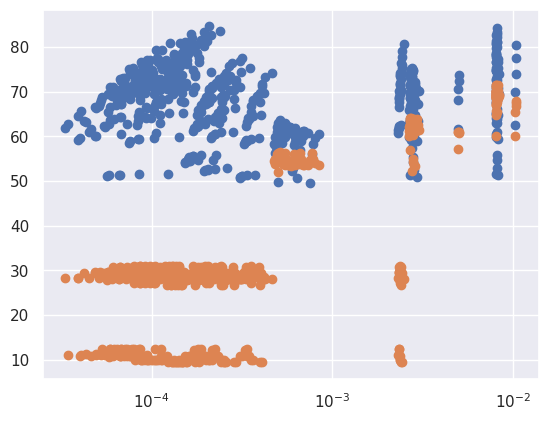

In [16]:
ota1_df_bc["gain"]=20*np.log10(ota1_df_bc["psrr_1stage"])
ota1_df_wc["gain"]=20*np.log10(ota1_df_wc["psrr_1stage"])

area_bc = ota1_df_bc["area"]
gain_bc = ota1_df_bc["gain"]

area_wc = ota1_df_wc["area"]
gain_wc = ota1_df_wc["gain"]

plt.scatter(area_bc, gain_bc)
plt.scatter(area_wc, gain_wc)
plt.xscale("log")

In [17]:
ota1_df_bc = ota1_df_bc.sort_values(by=["area"])
ota1_df_bc = ota1_df_bc[(ota1_df_wc['gain']>50) & (ota1_df_bc['gain']>70)]
ota1_df_bc

/tmp/ipykernel_26342/2081902547.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota1_df_bc = ota1_df_bc[(ota1_df_wc['gain']>50) & (ota1_df_bc['gain']>70)]


,Rdif_1,gdif_1,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Coutdif,Ccp,Raload_1,...,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain
103,3.864646e+07,0.000169,2.200,5.276312e+05,0.000169,1.050237e+06,0.000070,1.513217e-15,1.855719e-13,5.306967e+07,...,0.000024,8.000000e-07,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,71.567201
91,5.304206e+07,0.000141,2.200,1.121489e+06,0.000141,6.384905e+05,0.000074,9.868188e-16,9.102440e-14,5.306967e+07,...,0.000031,1.600000e-06,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,71.480136
106,8.214369e+07,0.000141,2.200,1.121489e+06,0.000141,1.050237e+06,0.000070,1.513217e-15,1.855719e-13,5.306967e+07,...,0.000031,1.600000e-06,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,73.174089
118,6.077527e+07,0.000169,2.200,5.276312e+05,0.000169,1.700883e+06,0.000068,2.325343e-15,3.745235e-13,5.306967e+07,...,0.000024,8.000000e-07,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,73.622184
92,4.938363e+07,0.000141,2.200,1.225006e+06,0.000141,3.542965e+05,0.000114,9.119971e-16,8.330449e-14,5.306967e+07,...,0.000031,1.600000e-06,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,71.149852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,6.399565e+07,0.000121,2.200,5.344207e+06,0.000121,6.801031e+04,0.000176,6.787911e-15,1.407324e-13,1.842210e+08,...,0.000088,6.400000e-06,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,75.193515
259,5.357605e+07,0.000121,2.200,5.344207e+06,0.000121,6.085610e+04,0.000165,1.857811e-14,2.972387e-13,1.842210e+08,...,0.000088,6.400000e-06,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,74.022409
199,4.409935e+07,0.000141,1.775,1.121489e+06,0.000141,1.425771e+05,0.000276,1.306994e-16,5.639626e-15,1.842210e+08,...,0.000031,1.600000e-06,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,74.034611
201,8.594633e+07,0.000127,1.775,2.185698e+06,0.000127,1.425771e+05,0.000276,1.306994e-16,5.639626e-15,1.842210e+08,...,0.000049,3.200000e-06,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,77.467145


In [18]:
ota1_df_wc = ota1_df_wc.sort_values(by=["area"])
ota1_df_wc = ota1_df_wc[(ota1_df_wc['gain']>50) & (ota1_df_bc['gain']>70)]
ota1_df_wc

/tmp/ipykernel_26342/2709486392.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota1_df_wc = ota1_df_wc[(ota1_df_wc['gain']>50) & (ota1_df_bc['gain']>70)]


,Rdif_1,gdif_1,Rdif_2,gdif_2,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m1_2,...,W_diff_m1,L_diff_m1,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain
103,1.919585e+08,0.000169,3.864646e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000024,8.000000e-07,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,63.795941
91,2.097373e+08,0.000141,5.304206e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000031,1.600000e-06,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,62.262034
106,4.080110e+08,0.000141,8.214369e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000031,1.600000e-06,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,62.450449
118,3.751637e+08,0.000169,6.077527e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000024,8.000000e-07,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,64.002725
92,2.425811e+08,0.000141,4.938363e+07,0.000141,-3.176657e-16,9.157720e-14,2.200,1.225006e+06,0.000141,1.225006e+06,...,0.000031,1.600000e-06,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,62.298995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2.577368e+09,0.000121,6.399565e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000088,6.400000e-06,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,68.908495
259,5.059918e+09,0.000121,5.357605e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000088,6.400000e-06,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,68.945872
199,4.525273e+07,0.000141,4.409935e+07,0.000141,-3.156878e-16,9.253736e-14,1.775,1.121489e+06,0.000141,1.121489e+06,...,0.000031,1.600000e-06,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,66.734539
201,8.819417e+07,0.000127,8.594633e+07,0.000127,-4.054649e-16,3.163520e-13,1.775,2.185698e+06,0.000127,2.185698e+06,...,0.000049,3.200000e-06,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,67.403590


### Comparation

In [19]:
W_diff_m1 = ota1_df_bc[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df_bc[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df_bc[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df_bc[Symbol("L_diff_m2")].values*1e6

W_al_m1 = ota1_df_bc[Symbol("W_aload_m1")].values*1e6
L_al_m1 = ota1_df_bc[Symbol("L_aload_m1")].values*1e6

W_al_m2 = ota1_df_bc[Symbol("W_aload_m2")].values*1e6
L_al_m2 = ota1_df_bc[Symbol("L_aload_m2")].values*1e6

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_m1):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM8": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias_dp": ota1_df_bc[Symbol("vbias")].values,
    "Vbias_cm": ota1_df_bc[Symbol("vbias_cm")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc_full", values)

[array([23.71430613, 31.16915315, 31.16915315, 23.71430613, 30.84236392,
       23.17735259, 31.16915315, 49.36406936, 30.84236392, 49.10278458,
       49.36406936, 49.10278458, 49.36406936, 23.17735259, 49.10278458,
       30.84236392, 88.39184516, 88.15314357, 88.39184516, 49.10278458,
       88.15314357, 88.39184516, 87.92911333, 88.15314357, 88.15314357,
       87.92911333, 87.92911333, 87.92911333, 87.92911333, 31.16915315,
       49.36406936, 88.39184516,  5.52957218, 23.71430613, 23.71430613,
       31.16915315, 23.17735259, 30.84236392, 31.16915315, 23.71430613,
       30.84236392, 23.17735259, 31.16915315, 49.36406936, 30.84236392,
       49.10278458, 49.36406936, 49.10278458, 49.36406936, 23.17735259,
       49.10278458, 30.84236392, 88.39184516, 88.15314357, 88.39184516,
       49.10278458, 88.15314357, 88.39184516, 87.92911333, 88.15314357,
       88.15314357, 48.86027157, 48.86027157, 87.92911333, 48.86027157,
       87.92911333, 87.92911333, 87.92911333, 31.16915315, 49.3

In [20]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df_bc["gain_sim"]=gain_error
ota1_df_bc["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df_bc["gain"].values)/np.asarray(gain_error))*100

In [21]:
ota1_df_bc

,Rdif_1,gdif_1,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Coutdif,Ccp,Raload_1,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain,gain_sim,gain_error
103,3.864646e+07,0.000169,2.200,5.276312e+05,0.000169,1.050237e+06,0.000070,1.513217e-15,1.855719e-13,5.306967e+07,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,71.567201,71.758910,0.267158
91,5.304206e+07,0.000141,2.200,1.121489e+06,0.000141,6.384905e+05,0.000074,9.868188e-16,9.102440e-14,5.306967e+07,...,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,71.480136,71.685903,0.287039
106,8.214369e+07,0.000141,2.200,1.121489e+06,0.000141,1.050237e+06,0.000070,1.513217e-15,1.855719e-13,5.306967e+07,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,73.174089,73.554937,0.517774
118,6.077527e+07,0.000169,2.200,5.276312e+05,0.000169,1.700883e+06,0.000068,2.325343e-15,3.745235e-13,5.306967e+07,...,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,73.622184,73.912617,0.392941
92,4.938363e+07,0.000141,2.200,1.225006e+06,0.000141,3.542965e+05,0.000114,9.119971e-16,8.330449e-14,5.306967e+07,...,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,71.149852,71.598114,0.626081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,6.399565e+07,0.000121,2.200,5.344207e+06,0.000121,6.801031e+04,0.000176,6.787911e-15,1.407324e-13,1.842210e+08,...,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,75.193515,76.632011,1.877148
259,5.357605e+07,0.000121,2.200,5.344207e+06,0.000121,6.085610e+04,0.000165,1.857811e-14,2.972387e-13,1.842210e+08,...,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,74.022409,75.190010,1.552868
199,4.409935e+07,0.000141,1.775,1.121489e+06,0.000141,1.425771e+05,0.000276,1.306994e-16,5.639626e-15,1.842210e+08,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,74.034611,74.263443,0.308135
201,8.594633e+07,0.000127,1.775,2.185698e+06,0.000127,1.425771e+05,0.000276,1.306994e-16,5.639626e-15,1.842210e+08,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,77.467145,77.761665,0.378746


In [22]:
W_diff_m1 = ota1_df_wc[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df_wc[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df_wc[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df_wc[Symbol("L_diff_m2")].values*1e6

W_al_m1 = ota1_df_wc[Symbol("W_aload_m1")].values*1e6
L_al_m1 = ota1_df_wc[Symbol("L_aload_m1")].values*1e6

W_al_m2 = ota1_df_wc[Symbol("W_aload_m2")].values*1e6
L_al_m2 = ota1_df_wc[Symbol("L_aload_m2")].values*1e6

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_m1):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM8": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias_dp": ota1_df_wc[Symbol("vbias")].values,
    "Vbias_cm": ota1_df_wc[Symbol("vbias_cm")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc_full_wc", values)

[array([23.71430613, 31.16915315, 31.16915315, 23.71430613, 30.84236392,
       23.17735259, 31.16915315, 49.36406936, 30.84236392, 49.10278458,
       49.36406936, 49.10278458, 49.36406936, 23.17735259, 49.10278458,
       30.84236392, 88.39184516, 88.15314357, 88.39184516, 49.10278458,
       88.15314357, 88.39184516, 87.92911333, 88.15314357, 88.15314357,
       87.92911333, 87.92911333, 87.92911333, 87.92911333, 31.16915315,
       49.36406936, 88.39184516,  5.52957218, 23.71430613, 23.71430613,
       31.16915315, 23.17735259, 30.84236392, 31.16915315, 23.71430613,
       30.84236392, 23.17735259, 31.16915315, 49.36406936, 30.84236392,
       49.10278458, 49.36406936, 49.10278458, 49.36406936, 23.17735259,
       49.10278458, 30.84236392, 88.39184516, 88.15314357, 88.39184516,
       49.10278458, 88.15314357, 88.39184516, 87.92911333, 88.15314357,
       88.15314357, 48.86027157, 48.86027157, 87.92911333, 48.86027157,
       87.92911333, 87.92911333, 87.92911333, 31.16915315, 49.3

Note: Dynamic gmin stepping completed

Note: No compatibility mode selected!


Circuit: ** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/sstadex/test/tesis_notebooks/xschem/ota_tb_ihp_cc_full_wc.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  1.00000e+00
No. of Data Rows : 91
Note: Simulation executed from .control section 
test numer:  1
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ota_tb_ihp_cc_full_wc.sch

**.subckt ota_tb_ihp_cc_full_wc

['I2', 'vs', 'vss', '2e-05']
I2 vs vss 2e-05 

XM1
['XM1', 'vcp', 'vp1', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=31.169153147599534u', 'ng=1', 'm=1']
XM1 vcp vp1 vs vs sg13_hv_nmos L=1.5999999999999999u W=31.169153147599534u ng=1 m=1 

XM2
['XM2', 'net2', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=1.5999999999999999u', 'W=31.169153147599534u', 'ng=1', 'm=1']
XM2 net2 vn vs vs sg13_hv_nmos L=1.5999999999999999u W=31.169153147599534u ng=1 m=1 

XM3
['XM3',

In [23]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df_wc["gain_sim"]=gain_error
ota1_df_wc["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df_wc["gain"].values)/np.asarray(gain_error))*100

In [24]:
ota1_df_wc

,Rdif_1,gdif_1,Rdif_2,gdif_2,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m1_2,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain,gain_sim,gain_error
103,1.919585e+08,0.000169,3.864646e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,63.795941,63.658374,0.216102
91,2.097373e+08,0.000141,5.304206e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,62.262034,62.269739,0.012374
106,4.080110e+08,0.000141,8.214369e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,62.450449,62.446124,0.006926
118,3.751637e+08,0.000169,6.077527e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,64.002725,63.852716,0.234929
92,2.425811e+08,0.000141,4.938363e+07,0.000141,-3.176657e-16,9.157720e-14,2.200,1.225006e+06,0.000141,1.225006e+06,...,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,62.298995,62.358686,0.095721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2.577368e+09,0.000121,6.399565e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,68.908495,68.710467,0.288206
259,5.059918e+09,0.000121,5.357605e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,68.945872,68.743646,0.294174
199,4.525273e+07,0.000141,4.409935e+07,0.000141,-3.156878e-16,9.253736e-14,1.775,1.121489e+06,0.000141,1.121489e+06,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,66.734539,66.631934,0.153987
201,8.819417e+07,0.000127,8.594633e+07,0.000127,-4.054649e-16,3.163520e-13,1.775,2.185698e+06,0.000127,2.185698e+06,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,67.403590,67.253442,0.223257


## 3. Build LDO

### Exploration

In [25]:
W_diff_m1 = ota1_df_wc[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df_wc[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df_wc[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df_wc[Symbol("L_diff_m2")].values

W_al_m1 = (ota1_df_wc[Symbol("W_aload_m1")].values)
L_al_m1 = (ota1_df_wc[Symbol("L_aload_m1")].values)

W_al_m2 = (ota1_df_wc[Symbol("W_aload_m2")].values)
L_al_m2 = (ota1_df_wc[Symbol("L_aload_m2")].values)

gm_OTA_ccdiff = ota1_df_wc["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df_wc["rout_1stage"].values

In [26]:
OTA_primitive = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol("vbias"): ota1_df_wc[Symbol("vbias")],
                                  Symbol("vbias_cm"): ota1_df_wc[Symbol("vbias_cm")]})
OTA_primitive.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al_m1"): W_al_m1,
                         Symbol("L_al_m1"): L_al_m1,
                         Symbol("W_al_m2"): W_al_m2,
                         Symbol("L_al_m2"): L_al_m2}

In [27]:
LDO_macro.ext_mask = None

LDO_macro.primitives=[OTA_primitive, pt_wc]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=-1
LDO_macro.specifications=[psrr_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results_wc, ldo_axes_wc, ldo_primouts_wc, ldo_df_wc, mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo
Netlist:  ldo_psrr
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0


[['vout', 'vdd']]
{<sstadex.models.primitives.Primitive object at 0x7fd428895f00>: {Ra: array([ 9147601.78768582,  9184555.93451188,  9383954.28557555,
        9365148.21479203,  9239281.15651116,  9191256.4116358 ,
        9490418.53182269,  9384333.38853978,  9412691.58760742,
        9237104.325345  ,  9490096.07573658,  9418422.78057533,
        9545677.33519084,  9388431.37140781,  9507703.59714385,
        9505398.36770066,  9488798.12951019,  9413198.59931013,
        9544730.37266899,  9554764.44314533,  9508548.73407991,
        9573884.5332283 ,  9179851.9248245 ,  9554846.17480213,
        9579079.04052575,  9534837.49274007,  9455012.87917787,
        9569006.53842408,  9586450.94653651,  7924990.01800967,
        8662264.98198714,  9090356.16912978, 20521632.76347169,
       18824900.1754962 , 20744273.75377877, 20935380.43017022,
       19199466.56449717, 19496825.17011653, 22001512.37684317,
       21898364.27417519, 21222035.31391387, 20970243.79108908,
       22596104.

In [28]:
W_diff_m1 = ota1_df_bc[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df_bc[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df_bc[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df_bc[Symbol("L_diff_m2")].values

W_al_m1 = (ota1_df_bc[Symbol("W_aload_m1")].values)
L_al_m1 = (ota1_df_bc[Symbol("L_aload_m1")].values)

W_al_m2 = (ota1_df_bc[Symbol("W_aload_m2")].values)
L_al_m2 = (ota1_df_bc[Symbol("L_aload_m2")].values)

gm_OTA_ccdiff = ota1_df_bc["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df_bc["rout_1stage"].values

In [29]:
OTA_primitive = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol('Ca'): ota1_df_bc[Symbol("Coutdif")].values+ota1_df_bc[Symbol("Cout")].values,
                                  Symbol('Ccpdif'): ota1_df_bc[Symbol("Ccp")].values,
                                  Symbol("Ccpaload_m1"): ota1_df_bc[Symbol("Ccp_m1")].values,
                                  Symbol("Ccpaload_m2"): ota1_df_bc[Symbol("Ccp_m2")].values,
                                  Symbol("vbias"): ota1_df_bc[Symbol("vbias")],
                                  Symbol("vbias_cm"): ota1_df_bc[Symbol("vbias_cm")]})
OTA_primitive.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al_m1"): W_al_m1,
                         Symbol("L_al_m1"): L_al_m1,
                         Symbol("W_al_m2"): W_al_m2,
                         Symbol("L_al_m2"): L_al_m2}

In [36]:
import sympy as sym

In [35]:
LDO_macro.A.subs([(Symbol("V1"), 1), (Symbol("Rl"), RL), (Symbol("R1"), R1), (Symbol("R2"), R2), (Symbol("I1"), 0)])	

Matrix([
[Ccpaload_m1*s + gaload_2 + 1/Raload_2,            -gdif_2,  gdif_2,                                  0,                                                              -Ccpaload_m1*s,                                                        0,                                         0,                           0,           0,  0],
[                                    0, gdif_2 + gdif_m1_1, -gdif_2,                                  0,                                                                           0,                                                        0,                                         0,                           0,           0,  0],
[                                    0,                  0,       0,                                  0,                                                                           0,                                                        0,                                         0,                           0,           0,  1],
[

In [37]:
eq = sym.Eq(LDO_macro.A * sym.Matrix(LDO_macro.X), sym.Matrix(LDO_macro.Z))
sol = sym.solve(eq, LDO_macro.X)

: 

In [31]:
LDO_macro.ext_mask = mask

LDO_macro.primitives=[OTA_primitive, pt_bc]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=1
LDO_macro.specifications=[psrr_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results, ldo_axes, ldo_primouts, ldo_df, mask, final_mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol_cap
Netlist:  ldo_psrr
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0
[['vout', 'vdd']]
Netlist:  ldo_ol_cap
Running MNA... 
   net1  vs  net3  net2  vss  net4  net5  vout  vfb  vpos
0     1   2     3     4    0     5     6     7    8     9


KeyboardInterrupt: 

In [211]:
ldo_df_wc = ldo_df_wc[final_mask]

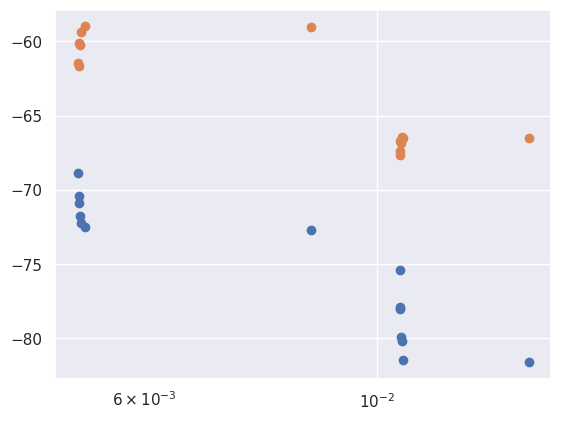

In [212]:
ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df_wc["gain"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

area = ldo_df["area"]
psrr = ldo_df["gain"]

area_wc = ldo_df_wc["area"]
psrr_wc = ldo_df_wc["gain"]

plt.scatter(area, psrr)
plt.scatter(area_wc, psrr_wc)
plt.xscale("log")

In [213]:
ldo_df[ldo_df["gain"]<-70]

,Ra,gma,Ca,vbias,vbias_cm,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,...,W_diff_m2,L_diff_m2,W_al_m1,L_al_m1,W_al_m2,L_al_m2,W_pt,L_pt,area,gain
2,3.225394e+07,0.000141,1.140625e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000300,...,0.000010,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005186,-70.447833
3,2.834688e+07,0.000169,1.218188e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000285,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005189,-70.895886
6,3.762612e+07,0.000141,1.483982e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000257,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005198,-71.787170
12,4.383643e+07,0.000127,2.202202e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000245,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005218,-72.213573
21,4.783125e+07,0.000121,3.981072e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000236,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005260,-72.529758
38,5.683537e+07,0.000141,1.218188e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000170,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010513,-75.372197
42,7.595345e+07,0.000141,1.584893e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000127,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010525,-77.891980
46,8.567391e+07,0.000127,2.061986e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000125,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010533,-78.036839
48,1.063941e+08,0.000127,2.351953e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000101,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010545,-79.918832
54,1.152743e+08,0.000121,3.490255e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000098,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010575,-80.173446


In [215]:
ldo_df_wc[ldo_df["gain"]<-70]

,Ra,gma,Ca,vbias,vbias_cm,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,...,W_diff_m2,L_diff_m2,W_al_m1,L_al_m1,W_al_m2,L_al_m2,W_pt,L_pt,area,gain
2,9.383954e+06,0.000141,1.140625e-17,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000985,...,0.000010,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005186,-60.131115
3,9.365148e+06,0.000169,1.218188e-17,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000827,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005189,-61.645812
6,9.490419e+06,0.000141,1.483982e-17,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000974,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005198,-60.227727
12,9.545677e+06,0.000127,2.202202e-17,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001071,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005218,-59.400858
21,9.573885e+06,0.000121,3.981072e-17,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001122,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005260,-58.997324
38,2.200151e+07,0.000141,1.218188e-16,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000426,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010513,-67.404000
42,2.259610e+07,0.000141,1.584893e-16,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000415,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010525,-67.634223
46,2.259428e+07,0.000127,2.061986e-16,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000460,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010533,-66.742895
48,2.291205e+07,0.000127,2.351953e-16,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000454,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010545,-66.863335
54,2.290659e+07,0.000121,3.490255e-16,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000477,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010575,-66.425102


### Comparation

In [223]:
W_diff_m1 = ldo_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ldo_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ldo_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ldo_df[Symbol("L_diff_m2")].values*1e6

W_al_m1 = ldo_df[Symbol("W_al_m1")].values*1e6
L_al_m1 = ldo_df[Symbol("L_al_m1")].values*1e6

W_al_m2 = ldo_df[Symbol("W_al_m2")].values*1e6
L_al_m2 = ldo_df[Symbol("L_al_m2")].values*1e6

W_pt = ldo_df[Symbol("W_pt")].values*1e6
L_pt = ldo_df[Symbol("L_pt")].values*1e6

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_m1):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM8": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM9": [
        W_pt,
        L_pt,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias_dp": ldo_df[Symbol("vbias")].values,
    "Vbias_cm": ldo_df[Symbol("vbias_cm")].values
}

simulation_results = spice_sim("ldo_sim_ihp_cc_full", values)

[array([23.71430613, 31.16915315, 23.71430613, 31.16915315, 49.36406936,
       88.39184516, 31.16915315, 31.16915315, 49.36406936, 49.36406936,
       88.39184516, 88.39184516, 88.39184516, 88.39184516]), array([0.8, 1.6, 0.8, 1.6, 3.2, 6.4, 1.6, 1.6, 3.2, 3.2, 6.4, 6.4, 6.4,
       6.4]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/Tesis_notebooks/xschem/ldo_sim_ihp_cc_full.sch

**.subckt ldo_sim_ihp_cc_full

R1 vout vfb 100000 m=1

R2 vfb vss 300000 m=1

Cl vout vss 1e-12 m=1

R3 vout vss 18 m=1

XM7
['XM7', 'net1', 'vbias_cm', 'net3', 'net3', 'sg13_hv_pmos', 'L=0.7999999999999999u', 'W=2636.0128817845957u', 'ng=1', 'm=1']
XM7 net1 vbias_cm net3 net3 sg13_hv_pmos L=0.7999999999999999u W=2636.0128817845957u ng=1 m=1 

['I2', 'vs', 'vss', '2e-05']
I2 vs vss 2e-05 

XM1
['XM1', 'vcp', 'vn', 'vs', 'vs', 'sg13_hv_nmos', 'L=0.7999999999999999u', 'W=23.714306129048534u', 'ng=1', 'm=1']
XM1 vcp vn vs 

In [224]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df["gain_sim"]=gain_error
ldo_df["gain_error"] = (np.abs(np.asarray(gain_error) - ldo_df["gain"].values)/np.asarray(np.abs(gain_error)))*100

In [225]:
ldo_df  

,Ra,gma,Ca,vbias,vbias_cm,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,...,W_al_m1,L_al_m1,W_al_m2,L_al_m2,W_pt,L_pt,area,gain,gain_sim,gain_error
0,2.238189e+07,0.000169,1.000000e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000361,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005178,-68.841113,-68.791088,0.072720
2,3.225394e+07,0.000141,1.140625e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000300,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005186,-70.447833,-70.678344,0.326142
3,2.834688e+07,0.000169,1.218188e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000285,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005189,-70.895886,-70.937935,0.059276
6,3.762612e+07,0.000141,1.483982e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000257,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005198,-71.787170,-72.118031,0.458777
12,4.383643e+07,0.000127,2.202202e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000245,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005218,-72.213573,-72.749167,0.736219
21,4.783125e+07,0.000121,3.981072e-17,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000236,...,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005260,-72.529758,-73.198618,0.913760
38,5.683537e+07,0.000141,1.218188e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000170,...,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010513,-75.372197,-75.266361,0.140616
42,7.595345e+07,0.000141,1.584893e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000127,...,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010525,-77.891980,-77.872258,0.025326
46,8.567391e+07,0.000127,2.061986e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000125,...,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010533,-78.036839,-78.157110,0.153884
48,1.063941e+08,0.000127,2.351953e-16,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000101,...,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010545,-79.918832,-80.143396,0.280204
